## Policy Lapse Prediction
## Data used for analysis is based on Integral P&C Admin System

### The SQL query in below cells will retreive data based on database credentials provide. Right now these credentials have been left empty for security reasons. Please enter relevant details before running this notebook further.

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

# For Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For Feature Selection
from sklearn.feature_selection import chi2, SelectKBest

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

C:\Users\tbhardwaj2\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Import Data

In [2]:
# Enter ip address and port number of the system where the database resides.
server   = *******
database = *******
username = *******
password = *******

In [3]:
# Add appropriate driver name
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [4]:
# Run Query
query = '''
select 
case
when
clnt.clttype = 'C'
then
'corporate_client'
when
clnt.clttype = 'P'
then
'personal_client'
end as 'client_type',
rtrim(t3582.longdesc) as 'client_sex',
rtrim(t3645ctrycode.longdesc) as 'client_country',
case
when
clnt.cltpcode = ''
then
'Unknown'
else
clnt.cltpcode
end as 'Client_Postal_Code', 
case 
when
clnt.occpcode = ''
then
'Unknown'
else
t3644.longdesc
end as 'client_occupation', 
case 
when 
clnt.cltdob <> 99999999
then
(CONVERT(int,CONVERT(char(8),getdate(),112))-CONVERT(char(8),clnt.cltdob,112))/10000
else
0
end
as 'Client_Age',
case 
when
clnt.marryd = ''
then
'Unknown'
else 
rtrim(t3571.longdesc)
end as 'client_marital_status',
case
when 
clnt.natlty = ''
then
'Unknown'
else
rtrim(t3645ctrycode.longdesc) 
end as 'client_nationality',
chdr.chdrnum as 'policy_number',
rtrim(t3623.longdesc) as 'policy_status', 
rtrim(t3681.longdesc) as 'policy_contract_type', 
rtrim(t4629.longdesc) as 'policy_renewal_type',
chdr.cownnum as 'policy_owner_number',
rtrim(t3625.longdesc) as 'policy_payment_plan',
rtrim(t3590.longdesc) as 'policy_billing_frequency',
rtrim(t3620.longdesc) as 'policy_billing_channel',
rtrim(t3594.longdesc) as 'policy_collection_channel',
chdr.nofrisks as 'number_of_risks',
rtrim(t3595.longdesc) as 'policy_territory',
case 
when
chdr.stcb = ''
then
'Unknown'
else
rtrim(t3596.longdesc)
end as 'policy_source_of_business',
case 
when
chdr.stcc = ''
then
'Unknown'
else
rtrim(t8100.longdesc)
end as 'policy_major_class',
case 
when
chdr.stcd = ''
then
'Unknown'
else
isnull(rtrim(tr872.longdesc),'Unknown')
end as 'policy_country',
case 
when
chdr.stce = ''
then
'Unknown'
else
rtrim(t3599.longdesc)
end as 'policy_distribution_channel',
chdr.zrenno as 'policy_renewal_number',
chdr.zendno as 'policy_endorsement_number', 
case 
when
chdr.zcomtyp = ''
then
'Unknown'
else
rtrim(th868.longdesc)
end as 'policy_commission_type',
case 
when
chdr.jacket = ''
then
'Unknown'
else
rtrim(t4685.longdesc)
end as 'policy_jacket_type',
case 
when
chdr.zpaymode = ''
then
'Unknown'
else
rtrim(tr880.longdesc)
end as 'policy_payment_mode',
case 
when
chdr.rnldurn = ''
then
'Unknown'
else
rtrim(t4627.longdesc)
end as 'policy_renewal_duration',
isnull(risk.rsktyp,'N/A') as 'policy_risk_attached',
isnull(risk.totsi,0) as 'risk_sum_insured',
isnull(risk.totpre,0) as 'risk_premium',
isnull(claim.number_of_claims,0) as 'number_of_claims',
case
when 
chdr.statcode = 'LA'
then
abs(datediff(day,convert(datetime,(convert(char(8), chdr.occdate))),convert(datetime,(convert(char(8), chdr.statdate)))) )
else
0
end as 'lapsed_after_N_days_from_date_of_purchase',
case
when 
chdr.statcode = 'LA'
then
abs(datediff(day,convert(datetime,(convert(char(8), chdr.crdate))),convert(datetime,(convert(char(8), chdr.statdate)))) )
else
0
end as 'lapsed_N_days_before_expiry_date',
case
when
chdr.statcode = 'LA' and lastest_claim.clameff <> null
then
abs(datediff(day,convert(datetime,(convert(char(8), lastest_claim.clameff))),convert(datetime,(convert(char(8), chdr.statdate)))) )
else
0
end as 'N_days_claim_raised_before_lapse',

case
when
chdr.statcode = 'LA' 
then
abs(datediff(day,convert(datetime,(convert(char(8), chdr.billcd))),convert(datetime,(convert(char(8), chdr.statdate)))) )
else
0
end as 'lapsed_N_days_before_next_billing',
case
when 
chdr.stcc = 'VEH'
then
'motor'
else
'non-motor'
end as 'classification',
case
when
chdr.statcode = 'LA'
then 
1
else
0
end as 'LAPSE_INDICATOR'
from
(
select chdr01.chdrnum, chdr01.statcode, chdr01.cnttype, chdr01.statreasn, chdr01.rnltype, chdr01.rnlnots, chdr01.rnlnotto, chdr01.statdate, chdr01.occdate,
chdr01.rnldurn, chdr01.cownnum, chdr01.payplan, chdr01.billfreq, chdr01.billchnl, chdr01.collchnl, chdr01.srcebus, chdr01.nofrisks, chdr01.stca, 
chdr01.stcb, chdr01.stcc, chdr01.stcd, chdr01.stce, chdr01.zrenno, chdr01.zendno, chdr01.zcomtyp, chdr01.tranno, chdr01.tranlused, chdr01.jacket,
chdr01.billcd, chdr01.zpaymode, chdr01.ccdate, chdr01.crdate
from 
(select unique_number, chdrnum, statcode, cnttype, statreasn, rnltype, rnlnots, rnlnotto, statdate, occdate, rnldurn, cownnum, payplan, billfreq, 
billchnl, collchnl, srcebus, nofrisks, stca, stcb, stcc, stcd, stce, zrenno, zendno, zcomtyp, tranno, tranlused, jacket, billcd, zpaymode,ccdate, crdate
from vm1dta.chdrpf where servunit = 'FG' and statcode in ('IF', 'LA', 'FR', 'SR') )chdr01 
inner join 
(select servunit, chdrnum, max(unique_number) as max_unique_number from vm1dta.chdrpf  where servunit = 'FG' and statcode in ('IF', 'LA', 'FR', 'SR')
group by servunit, chdrnum)chdr02
on chdr02.chdrnum = chdr01.chdrnum and chdr02.max_unique_number = chdr01.unique_number
) chdr
inner join
(select clttype, clntnum, cltsex, ctrycode, cltpcode, occpcode, cltdob, marryd, natlty from vm1dta.clntpf where validflag = '1' and cltind = 'C'
and cltstat = 'AC') clnt
on clnt.clntnum = chdr.cownnum
left outer join 
(select chdrnum, count(distinct claim) as number_of_claims from vm1dta.clampf group by chdrnum)claim
on claim.chdrnum = chdr.chdrnum
left outer join 
(select clam01.chdrnum, clam01.claim, clam01.clameff, clam01.rsktyp, clam01.balo 
from
(select unique_number, chdrnum, claim, clameff, rsktyp, balo  from vm1dta.clampf where validflag = '1')   clam01 
inner join 
(select max(unique_number) as latest_claim_tx, chdrnum  from vm1dta.clampf group by chdrnum) clam02 
on clam02.latest_claim_tx = clam01.unique_number)lastest_claim
on lastest_claim.chdrnum = chdr.chdrnum


left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '9' and desctabl = 'T3582')t3582
on t3582.descitem = (case when clnt.cltsex = '' then 'U' else clnt.cltsex end)
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '9' and desctabl = 'T3645')t3645ctrycode
on t3645ctrycode.descitem = clnt.ctrycode
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '9' and desctabl = 'T3644')t3644
on t3644.descitem = clnt.occpcode
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '9' and desctabl = 'T3571')t3571
on t3571.descitem = clnt.marryd
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '9' and desctabl = 'T3645')t3645natlty
on t3645natlty.descitem = clnt.natlty
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3623')t3623
on t3623.descitem = chdr.statcode
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3681')t3681
on t3681.descitem = chdr.cnttype
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T4629')t4629
on t4629.descitem = chdr.rnltype
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3625')t3625
on t3625.descitem = chdr.payplan
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3590')t3590
on t3590.descitem = chdr.billfreq
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3620')t3620
on t3620.descitem = chdr.billchnl
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3594')t3594
on t3594.descitem = chdr.collchnl
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3596')t3596
on t3596.descitem = chdr.stcb
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3595')t3595
on t3595.descitem = chdr.stca
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T8100')t8100
on t8100.descitem = chdr.stcc
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T3599')t3599
on t3599.descitem = chdr.stce
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'TR872')tr872
on tr872.descitem = chdr.stcd
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'TH868')th868
on th868.descitem = chdr.zcomtyp
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T4685')t4685
on t4685.descitem = chdr.jacket
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'TR880')tr880
on tr880.descitem = chdr.zpaymode
left outer join 
(select descitem, longdesc from vm1dta.descpf where language = 'E' and descpfx = 'IT' and desccoy = '1' and desctabl = 'T4627')t4627
on t4627.descitem = chdr.rnldurn
left outer join 
(select distinct chdrno, rsktyp, totsi,totpre, tranno from vm1dta.riskpf) risk
on risk.chdrno = chdr.chdrnum and risk.tranno = chdr.tranno

order by chdr.chdrnum
'''

In [5]:
# Read data
df_orig = pd.read_sql(query,cnxn)

# Close the cursor
cursor.close() 

In [6]:
# Check data sample
df_orig.head()

,client_type,client_sex,client_country,Client_Postal_Code,client_occupation,Client_Age,client_marital_status,client_nationality,policy_number,policy_status,policy_contract_type,policy_renewal_type,policy_owner_number,policy_payment_plan,policy_billing_frequency,policy_billing_channel,policy_collection_channel,number_of_risks,policy_territory,policy_source_of_business,policy_major_class,policy_country,policy_distribution_channel,policy_renewal_number,policy_endorsement_number,policy_commission_type,policy_jacket_type,policy_payment_mode,policy_renewal_duration,policy_risk_attached,risk_sum_insured,risk_premium,number_of_claims,lapsed_after_N_days_from_date_of_purchase,lapsed_N_days_before_expiry_date,N_days_claim_raised_before_lapse,lapsed_N_days_before_next_billing,classification,LAPSE_INDICATOR
0,personal_client,Female,Singapore,Unknown,Unknown,31,Single,Singapore,00001135,First Reminder,Hospital & Surgical,Midnight Renewals,0001794,Direct Bill - No Instalment,Single Premium,Agent,Direct from Policyholder,1,LOCAL INSURANCE FUND,Brokers,Misc Accident - Major Class,Singapore,Unknown,0,0,Agent Net Commission,Standard Wording and Sleeve,Unknown,Twelve months,HOS,0,25000.00,0,0,0,0,0,non-motor,0
1,personal_client,Female,Singapore,Unknown,Unknown,31,Single,Singapore,00001137,First Reminder,Hospital & Surgical,Midnight Renewals,0001794,Direct Bill - No Instalment,Single Premium,Agent,Direct from Policyholder,1,LOCAL INSURANCE FUND,Brokers,Misc Accident - Major Class,Singapore,Unknown,0,0,Agent Net Commission,Standard Wording and Sleeve,Unknown,Twelve months,HOS,0,25000.00,0,0,0,0,0,non-motor,0
2,corporate_client,Unknown,Singapore,Unknown,Unknown,0,Unknown,Unknown,00008460,In Force,Commercial Vehicle,Midnight Renewals,50081120,Direct Bill - No Instalment,Single Premium,Agent,Direct from Policyholder,1,LOCAL INSURANCE FUND,Brokers,Motor - Major Class,Singapore,Unknown,0,0,Gross Commission,Standard Wording and Sleeve,Unknown,Twelve months,VGC,210000,22768.54,0,0,0,0,0,motor,0
3,corporate_client,Unknown,India,62,Unknown,2,Unknown,Unknown,00008481,In Force,Commercial Vehicle,Midnight Renewals,50001118,Direct Bill - No Instalment,Single Premium,Agent,Direct from Policyholder,1,LOCAL INSURANCE FUND,Brokers,Motor - Major Class,Singapore,Unknown,0,0,Agent Net Commission,Standard Wording and Sleeve,Unknown,Twelve months,VGC,200000,2927.00,0,0,0,0,0,motor,0
4,corporate_client,Unknown,Singapore,Unknown,Unknown,0,Unknown,Unknown,35000001,In Force,Public Liability,Midnight Renewals,50002496,Direct Bill - No Instalment,Single Premium,Agent,Direct from Policyholder,1,LOCAL INSURANCE FUND,Brokers,Misc Accident - Major Class,Singapore,Unknown,0,0,Net Commission,Standard Wording and Sleeve,Unknown,Twelve months,LPL,0,10000.00,0,0,0,0,0,non-motor,0


## Data Analysis & Visualization

In [7]:
# Check data shape
df_orig.shape

(14152, 39)

In [8]:
# Check data attributes of the columns
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14152 entries, 0 to 14151
Data columns (total 39 columns):
client_type                                  14152 non-null object
client_sex                                   14152 non-null object
client_country                               14152 non-null object
Client_Postal_Code                           14152 non-null object
client_occupation                            14152 non-null object
Client_Age                                   14152 non-null int64
client_marital_status                        14152 non-null object
client_nationality                           14152 non-null object
policy_number                                14152 non-null object
policy_status                                14152 non-null object
policy_contract_type                         14151 non-null object
policy_renewal_type                          14152 non-null object
policy_owner_number                          14152 non-null object
policy_payment_plan  

In [9]:
# View distribution of 'Lapse' Instances
df_orig['LAPSE_INDICATOR'].value_counts()

0    14053
1       99
Name: LAPSE_INDICATOR, dtype: int64

In [10]:
# Check if there are any nulls
df_orig.isnull().sum()

client_type                                    0
client_sex                                     0
client_country                                 0
Client_Postal_Code                             0
client_occupation                              0
Client_Age                                     0
client_marital_status                          0
client_nationality                             0
policy_number                                  0
policy_status                                  0
policy_contract_type                           1
policy_renewal_type                            0
policy_owner_number                            0
policy_payment_plan                            0
policy_billing_frequency                       0
policy_billing_channel                         0
policy_collection_channel                      0
number_of_risks                                0
policy_territory                               0
policy_source_of_business                      0
policy_major_class  

c:\users\tbhardwaj2\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
c:\users\tbhardwaj2\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


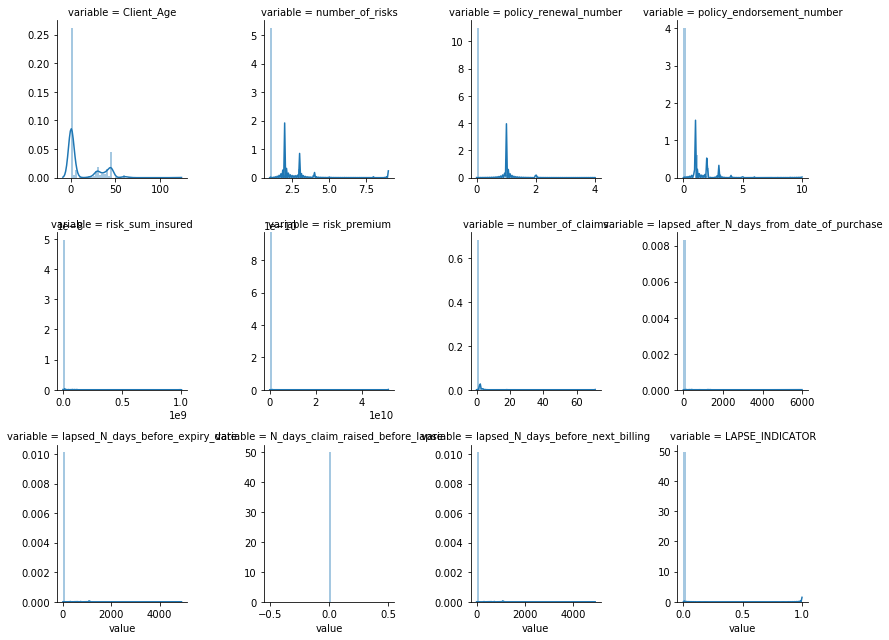

In [11]:
# Study distribution of Numerical Columns
num = [f for f in df_orig.columns if df_orig.dtypes[f] != 'object']
nd = pd.melt(df_orig, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

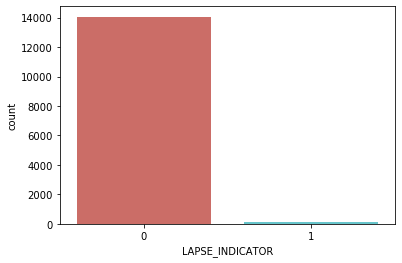

In [12]:
# Plot count values
df_orig.LAPSE_INDICATOR.value_counts()
sns.countplot(x = 'LAPSE_INDICATOR', data = df_orig, palette = 'hls')
plt.show()

## Data Treatment

In [13]:
# Separate features into categorical and numerical category
cat_vars = ['client_type','client_sex','Client_Postal_Code','client_country','client_occupation','client_marital_status',
            'client_nationality','policy_status','policy_contract_type','policy_renewal_type',
            'policy_payment_plan','policy_billing_frequency','policy_billing_channel',
            'policy_collection_channel','policy_territory','policy_source_of_business','policy_major_class',
            'policy_country','policy_distribution_channel','policy_renewal_number','policy_endorsement_number',
            'policy_commission_type','policy_jacket_type','policy_payment_mode','policy_renewal_duration',
            'policy_risk_attached','classification']

num_vars = ['risk_sum_insured', 'risk_premium', 'number_of_claims','lapsed_after_N_days_from_date_of_purchase',
           'lapsed_N_days_before_expiry_date','N_days_claim_raised_before_lapse','lapsed_N_days_before_next_billing']

In [14]:
# Create a copy of dataframe
df_work = df_orig.copy()

In [15]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [16]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [17]:
# Check data shape after dummy encoding
df_work.shape

(14152, 398)

In [18]:
# Remove original columns for which dummy variables have been created
vars_remove = ['client_type','client_sex','Client_Postal_Code','client_country','client_occupation','client_marital_status',
               'client_nationality','policy_number','policy_status','policy_contract_type','policy_renewal_type',
               'policy_owner_number','policy_payment_plan','policy_billing_frequency','policy_billing_channel',
               'policy_collection_channel','policy_territory','policy_source_of_business','policy_major_class',
               'policy_country','policy_distribution_channel','policy_renewal_number','policy_endorsement_number',
               'policy_commission_type','policy_jacket_type','policy_payment_mode','policy_renewal_duration',
               'policy_risk_attached','classification']

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [19]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['risk_sum_insured'] = scaler.fit_transform(df_work['risk_sum_insured'].values.reshape(-1,1))
df_work['risk_premium'] = scaler.fit_transform(df_work['risk_premium'].values.reshape(-1,1))

In [20]:
# Create separate dataset for feature and target columns
x = df_work.drop('LAPSE_INDICATOR', axis=1)
y = df_work['LAPSE_INDICATOR']

## Feature Selection

In [21]:
bestfeatures=SelectKBest(score_func=chi2, k=10)
fit=bestfeatures.fit(x,y)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x.columns)
#concatenate two dataframes
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features


                                         Specs         Score
6             lapsed_N_days_before_expiry_date  1.200921e+07
8            lapsed_N_days_before_next_billing  1.188941e+07
5    lapsed_after_N_days_from_date_of_purchase  4.697251e+06
68                        policy_status_Lapsed  1.405300e+04
0                                   Client_Age  1.400529e+03
103          policy_contract_type_Fire Takaful  9.823632e+02
267                   policy_risk_attached_FIO  2.947023e+02
219                    policy_renewal_number_1  1.539616e+02
293                   policy_risk_attached_LPP  1.246215e+02
4                             number_of_claims  7.380072e+01


In [22]:
# Get top features, feature 'policy_status_Lapsed' has been left intentionally
top_features = ['lapsed_N_days_before_expiry_date', 'lapsed_N_days_before_next_billing', 
               'lapsed_after_N_days_from_date_of_purchase','Client_Age',
               'policy_contract_type_Fire Takaful', 'policy_risk_attached_FIO', 'policy_renewal_number_1',
               'policy_risk_attached_LPP','number_of_claims']

In [23]:
# Create new dataset with only top features
x01=x[top_features]
y01=y

In [24]:
# Perform Test/Train Split
x01_train, x01_test, y01_train, y01_test=train_test_split(x01, y01, test_size=0.3,random_state=11)

In [25]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

#X4_train, X4_test, Y4_train, Y4_test = train_test_split(X_train,Y_train, test_size=0.20)
x01_train_smo,y01_train_smo = SMO.fit_sample(x01_train, y01_train)
columns = x01_train.columns

x01_train_smo = pd.DataFrame(data = x01_train_smo, columns = columns )
y01_train_smo = pd.DataFrame(data = y01_train_smo, columns = ['LAPSE_INDICATOR'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x01_train_smo))
print("Number of non lapsed policies in oversampled data",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 0 ]))
print("Number of lapsed policies in oversampled data",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 1 ]))
print("Proportion of non lapsed policies in oversampled data is ",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 0])/len(x01_train_smo))
print("Proportion of lapsed policies in oversampled data is ",len(y01_train_smo[y01_train_smo['LAPSE_INDICATOR']== 1 ])/len(x01_train_smo))

C:\Users\tbhardwaj2\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\tbhardwaj2\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\tbhardwaj2\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensem

length of oversampled data is  19674
Number of non lapsed policies in oversampled data 9837
Number of lapsed policies in oversampled data 9837
Proportion of non lapsed policies in oversampled data is  0.5
Proportion of lapsed policies in oversampled data is  0.5


## Model Application

### Logistic Regression with StratifiedKFold with set of weights provided.  Also use Gridsearch to obtain optimal parameters. 

In [26]:
# Define grid
C = np.logspace(0,5,10)
param_grid = dict( C=C)

# Model
logreg=LogisticRegression(solver='lbfgs',max_iter=1000)

# Define Evaluation Procedure
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=11)

# Define Grid Search
grid=GridSearchCV(estimator=logreg, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Execute Grid Search
grid_result=grid.fit(x01_train_smo, (y01_train_smo.values.ravel()))


In [27]:
# Print best model parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 1.000000 using {'C': 1.0}


In [28]:
grid_result.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# Saving the best model
bestlogreg= LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
# Fit the model on train data
bestlogreg.fit(x01_train, y01_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
# Make Predictions
y01_pred=bestlogreg.predict(x01_test)

In [32]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y01_test, y01_pred)
cnf_matrix

array([[4216,    0],
       [   0,   30]], dtype=int64)

In [33]:
# Get Accuracy Scores
print("Accuracy:",metrics.accuracy_score(y01_test, y01_pred))
print("Precision:",metrics.precision_score(y01_test, y01_pred))
print("Recall:",metrics.recall_score(y01_test, y01_pred))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


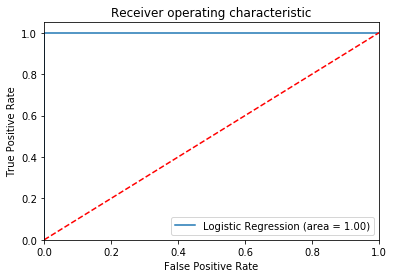

In [34]:
# Print ROC AUC Curve

logit_roc_auc = roc_auc_score(y01_test, bestlogreg.predict(x01_test))
fpr, tpr, thresholds = roc_curve(y01_test, bestlogreg.predict_proba(x01_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Save the model as PMML File

In [35]:
# Save the model as a pmml and use to make predictions in a file 

joblib.dump(bestlogreg, 'PnCPolicyLapseModel.pmml') 

['PnCPolicyLapseModel.pmml']

### Run the model on entire dataset and save the output in a csv file

In [36]:
# Copy the original data set
df_test = df_orig.copy()

In [37]:
# Separate features into categorical and numerical category
cat_vars = ['client_type','client_sex','Client_Postal_Code','client_country','client_occupation','client_marital_status',
            'client_nationality','policy_status','policy_contract_type','policy_renewal_type',
            'policy_payment_plan','policy_billing_frequency','policy_billing_channel',
            'policy_collection_channel','policy_territory','policy_source_of_business','policy_major_class',
            'policy_country','policy_distribution_channel','policy_renewal_number','policy_endorsement_number',
            'policy_commission_type','policy_jacket_type','policy_payment_mode','policy_renewal_duration',
            'policy_risk_attached','classification']

num_vars = ['risk_sum_insured', 'risk_premium', 'number_of_claims','lapsed_after_N_days_from_date_of_purchase',
           'lapsed_N_days_before_expiry_date','N_days_claim_raised_before_lapse','lapsed_N_days_before_next_billing']

In [38]:
# Convert to 'category' object type
for var in cat_vars:
    df_test[var] = df_test[var].astype('category')

In [39]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_test[var], prefix=var)
    dummy_data = df_test.join(cat_list)
    df_test = dummy_data

In [40]:
# Remove original columns for which dummy variables have been created
vars_remove = ['client_type','client_sex','Client_Postal_Code','client_country','client_occupation','client_marital_status',
               'client_nationality','policy_number','policy_status','policy_contract_type','policy_renewal_type',
               'policy_owner_number','policy_payment_plan','policy_billing_frequency','policy_billing_channel',
               'policy_collection_channel','policy_territory','policy_source_of_business','policy_major_class',
               'policy_country','policy_distribution_channel','policy_renewal_number','policy_endorsement_number',
               'policy_commission_type','policy_jacket_type','policy_payment_mode','policy_renewal_duration',
               'policy_risk_attached','classification']

for var in vars_remove:
    df_test=df_test.drop(var, axis=1)

In [41]:
# Get top features
top_features = ['lapsed_N_days_before_expiry_date', 'lapsed_N_days_before_next_billing', 
               'lapsed_after_N_days_from_date_of_purchase','Client_Age',
               'policy_contract_type_Fire Takaful', 'policy_risk_attached_FIO', 'policy_renewal_number_1',
               'policy_risk_attached_LPP','number_of_claims']

In [42]:
# Retain only top features in the datframe
df_test=df_test[top_features]

In [43]:
# Make predictions
prediction_class = bestlogreg.predict(df_test)
prediction_prob = bestlogreg.predict_proba(df_test)

# Get Individual Probabilities
not_lapse, lapse = (prediction_prob).T

In [44]:
# Save original dataframe in a separate dataframe
df_results = df_orig.copy()

In [45]:
# Remove target column
df_results=df_results.drop('LAPSE_INDICATOR',axis=1)

In [47]:
# On a policy multiple risks could be attached. Due to this in the df_results dataframe we end up having
# multiple rows for a policy with same predictions and probability values. This will cause issue when the output
# csv will be used for visualization as csv will have multiple rows for a policy.
# Hence columns pertaining to risk details are being dropped here and only one unique row will be retained for a policy by 
# executing drop_duplicates command in subsequent cells

df_results=df_results.drop('policy_risk_attached',axis=1)
df_results=df_results.drop('risk_sum_insured',axis=1)
df_results=df_results.drop('risk_premium',axis=1)


In [48]:
# Replace target column with predicted value of '0' or '1' along with respective probablities
df_results['notlapse'] = not_lapse
df_results['lapse'] = lapse
df_results['lapse_prediction_class'] = prediction_class

### Though care has been taken in testing the query output, still double check for duplicate rows for a policy in the csv file

In [49]:
# Drop Duplicate rows, since probability calculations are done using risk details also. So there were same cases wherein 
# for a policy all columns (after dropping risk details in above cell) are same except the probability values calculated.
# which were different by a small margin. So with 'subset' parameter we will delete rows having same policy_number value
# and retaining only the first instance

df_results.drop_duplicates(subset ='policy_number', keep='first',inplace=True) 

In [50]:
df_results.to_csv('EX_SOURCE_POLICY_LAPSE_PNC.csv', index = None, header=True) 